# Price Plots

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras


import os

import math


from tensorflow.keras.utils import Sequence
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'


## Ethereum (Hour)

In [16]:

# Load the data and preprocess it into train, validation, and test sets 
df = pd.read_csv('../data/latest_hour_final_ada.csv')

df.drop(columns=['Unnamed: 0','datetime','DATE'], inplace=True)

scaler = MinMaxScaler()


# Fit the scaler on your dataframe (let's say it's called df)
df_normalized = scaler.fit_transform(df)

# Convert the normalized data back to a dataframe
df_normalized = pd.DataFrame(df_normalized, columns=df.columns)


# Convert the DataFrame to a NumPy array
raw_data = df_normalized.values
close = df_normalized['close'].values
close = close.reshape((len(close),1))

print('Prep Data')
num_train_samples = int(0.6 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)


# Display the NumPy array
print(type(raw_data))
print(raw_data.shape)
print(close.shape)


Prep Data
num_train_samples: 11658
num_val_samples: 4857
num_test_samples: 2915
<class 'numpy.ndarray'>
(19430, 72)
(19430, 1)


The timeseries will consist of batches containing 32 sequences of 96 samples.
Finally our target is 1 timesteps in the future, and will have data from 192 timesteps in the past
Done Train
Done Validation
Done Test


2023-05-15 12:43:40.792085: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-15 12:43:40.793981: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-15 12:43:40.795369: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

13/86 [===>..........................] - ETA: 0s

2023-05-15 12:43:42.792946: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_20' with dtype double and shape [2914,1]
	 [[{{node Placeholder/_20}}]]
2023-05-15 12:43:42.793510: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_28' with dtype int32 and shape [2723]
	 [[{{node Placeholder/_28}}]]


86/86 [==============================] - 1s 9ms/step
True 4666 4666
False 2723 2724


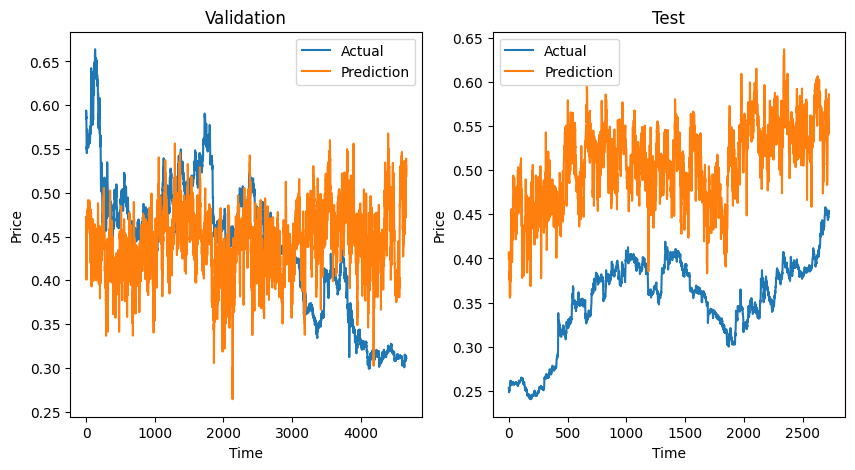

In [17]:
# Set Parameters

# delay: time in future that will be predicted
delay = 1


# sampling rate: period between timesteps within the sequence
# Sequence with rate=1 : t1,t2...tn
# Sequence with rate=3 : t1,t3...tn*3
sampling_rate = 2

# sequence length: sequence lenght of each sample 
sequence_length = 4 * 24


# sequence_stride: period between sequences
# First sequence starts at t0
# Second sequence will start at t1 with sequence_stride=1 or at t5 with sequence_stride=5
sequence_stride = 1

#batch_size: Number of timeseries samples in each batch (except maybe the last one). 
#If None, the data will not be batched (the dataset will yield individual samples).
# Huge impact in performance.
# Tip, should be multiple of 8
batch_size = 32

# Understanding our parameters
msg = f"The timeseries will consist of batches containing {batch_size} sequences of {sequence_length} samples."

msg += f"\nFinally our target is {delay} timesteps in the future, and will have data from {sequence_length * sampling_rate} timesteps in the past"
print(msg)

train_dataset = keras.preprocessing.timeseries_dataset_from_array(
                        raw_data[:-delay],
                    targets=close[delay:],
                    sampling_rate=sampling_rate,
                    sequence_stride=sequence_stride,
                    sequence_length=sequence_length,
                    shuffle=False, # Shouldn't the shuffle be set to 0?
                    seed=33,
                    batch_size=batch_size,
                    start_index=0,
                    end_index=num_train_samples)

print("Done Train")

val_dataset = keras.preprocessing.timeseries_dataset_from_array(
                    raw_data[:-delay],
                    targets=close[delay:],
                    sampling_rate=sampling_rate,
                    sequence_stride=sequence_stride,
                    sequence_length=sequence_length,
                    shuffle=False,
                    seed=33,
                    batch_size=batch_size,
                    start_index=num_train_samples,
                    end_index=num_train_samples + num_val_samples)

print("Done Validation")      

test_dataset = keras.preprocessing.timeseries_dataset_from_array(
                    raw_data[:-delay],
                    targets=close[delay:],
                    sampling_rate=sampling_rate,
                    sequence_stride=sequence_stride,
                    sequence_length=sequence_length,
                    shuffle=False,
                    seed=33,
                    batch_size=batch_size,
                    start_index=num_train_samples + num_val_samples)

print("Done Test")


# Load the saved model
model = keras.models.load_model("ADA/lstm_model_1_ahead.h5")
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

val_pred = model.predict(val_dataset)
test_pred = model.predict(test_dataset)


val_real = close[num_train_samples:num_train_samples + num_val_samples- (sequence_length * sampling_rate)+1]
test_real = close[num_train_samples + num_val_samples:-(sequence_length * sampling_rate)+1]

print(len(val_pred) == len(val_real), len(val_pred) , len(val_real), )
print(len(test_pred) == len(test_real), len(test_pred) , len(test_real))


# Assume 'y_normalized' contains the predicted values for the 'target' column in normalized form
y_min = df['close'].min()
y_max = df['close'].max()

val_real = val_real * (y_max - y_min) + y_min
val_pred = val_pred * (y_max - y_min) + y_min

test_real = test_real * (y_max - y_min) + y_min
test_pred = test_pred * (y_max - y_min) + y_min

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))

# Plot a and b in the left-hand subplot
ax1.set_title('Validation')
ax1.plot(val_real, label='Actual')
ax1.plot(val_pred, label='Prediction')
ax1.set_xlabel('Time')
ax1.set_ylabel('Price')
ax1.legend()

# Plot c and d in the right-hand subplot
ax2.set_title('Test')
ax2.plot(test_real, label='Actual')
ax2.plot(test_pred, label='Prediction')
ax2.set_xlabel('Time')
ax2.set_ylabel('Price')
ax2.legend()

# Display the plot
plt.show()

The timeseries will consist of batches containing 32 sequences of 96 samples.
Finally our target is 3 timesteps in the future, and will have data from 192 timesteps in the past
Done Train
Done Validation
Done Test


2023-05-14 17:27:36.267413: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-14 17:27:36.269025: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-14 17:27:36.270340: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

  1/146 [..............................] - ETA: 1:04

2023-05-14 17:27:36.617202: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-14 17:27:36.619016: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-14 17:27:36.620565: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

13/86 [===>..........................] - ETA: 0s

2023-05-14 17:27:38.240207: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_28' with dtype int32 and shape [2721]
	 [[{{node Placeholder/_28}}]]
2023-05-14 17:27:38.240751: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [2721]
	 [[{{node Placeholder/_8}}]]


86/86 [==============================] - 1s 9ms/step
True 4666 4666
False 2721 2724


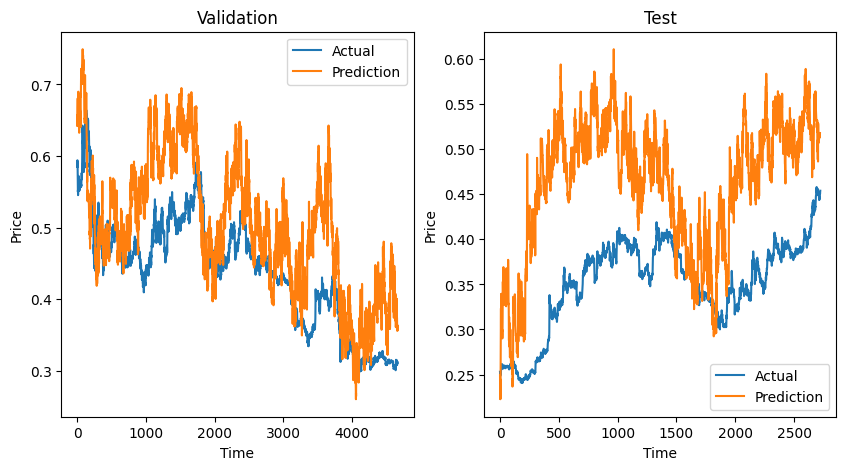

In [4]:
# Set Parameters

# delay: time in future that will be predicted
delay = 3


# sampling rate: period between timesteps within the sequence
# Sequence with rate=1 : t1,t2...tn
# Sequence with rate=3 : t1,t3...tn*3
sampling_rate = 2

# sequence length: sequence lenght of each sample 
sequence_length = 4 * 24


# sequence_stride: period between sequences
# First sequence starts at t0
# Second sequence will start at t1 with sequence_stride=1 or at t5 with sequence_stride=5
sequence_stride = 1

#batch_size: Number of timeseries samples in each batch (except maybe the last one). 
#If None, the data will not be batched (the dataset will yield individual samples).
# Huge impact in performance.
# Tip, should be multiple of 8
batch_size = 32

# Understanding our parameters
msg = f"The timeseries will consist of batches containing {batch_size} sequences of {sequence_length} samples."

msg += f"\nFinally our target is {delay} timesteps in the future, and will have data from {sequence_length * sampling_rate} timesteps in the past"
print(msg)

train_dataset = keras.preprocessing.timeseries_dataset_from_array(
                        raw_data[:-delay],
                    targets=close[delay:],
                    sampling_rate=sampling_rate,
                    sequence_stride=sequence_stride,
                    sequence_length=sequence_length,
                    shuffle=False, # Shouldn't the shuffle be set to 0?
                    seed=33,
                    batch_size=batch_size,
                    start_index=0,
                    end_index=num_train_samples)

print("Done Train")

val_dataset = keras.preprocessing.timeseries_dataset_from_array(
                    raw_data[:-delay],
                    targets=close[delay:],
                    sampling_rate=sampling_rate,
                    sequence_stride=sequence_stride,
                    sequence_length=sequence_length,
                    shuffle=False,
                    seed=33,
                    batch_size=batch_size,
                    start_index=num_train_samples,
                    end_index=num_train_samples + num_val_samples)

print("Done Validation")      

test_dataset = keras.preprocessing.timeseries_dataset_from_array(
                    raw_data[:-delay],
                    targets=close[delay:],
                    sampling_rate=sampling_rate,
                    sequence_stride=sequence_stride,
                    sequence_length=sequence_length,
                    shuffle=False,
                    seed=33,
                    batch_size=batch_size,
                    start_index=num_train_samples + num_val_samples)

print("Done Test")


# Load the saved model
model = keras.models.load_model("ADA/lstm_model_3_ahead.h5")
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

val_pred = model.predict(val_dataset)
test_pred = model.predict(test_dataset)


val_real = close[num_train_samples:num_train_samples + num_val_samples- (sequence_length * sampling_rate)+1]
test_real = close[num_train_samples + num_val_samples:-(sequence_length * sampling_rate)+1]

print(len(val_pred) == len(val_real), len(val_pred) , len(val_real), )
print(len(test_pred) == len(test_real), len(test_pred) , len(test_real))


# Assume 'y_normalized' contains the predicted values for the 'target' column in normalized form
y_min = df['close'].min()
y_max = df['close'].max()

val_real = val_real * (y_max - y_min) + y_min
val_pred = val_pred * (y_max - y_min) + y_min

test_real = test_real * (y_max - y_min) + y_min
test_pred = test_pred * (y_max - y_min) + y_min

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))

# Plot a and b in the left-hand subplot
ax1.set_title('Validation')
ax1.plot(val_real, label='Actual')
ax1.plot(val_pred, label='Prediction')
ax1.set_xlabel('Time')
ax1.set_ylabel('Price')
ax1.legend()

# Plot c and d in the right-hand subplot
ax2.set_title('Test')
ax2.plot(test_real, label='Actual')
ax2.plot(test_pred, label='Prediction')
ax2.set_xlabel('Time')
ax2.set_ylabel('Price')
ax2.legend()

# Display the plot
plt.show()

The timeseries will consist of batches containing 32 sequences of 96 samples.
Finally our target is 6 timesteps in the future, and will have data from 192 timesteps in the past
Done Train
Done Validation
Done Test


2023-05-14 17:27:39.883303: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-14 17:27:39.884977: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-14 17:27:39.886366: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

  7/146 [>.............................] - ETA: 1s  

2023-05-14 17:27:40.237827: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-14 17:27:40.240007: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-14 17:27:40.241598: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

14/85 [===>..........................] - ETA: 0s

2023-05-14 17:27:41.833763: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_13' with dtype int32
	 [[{{node Placeholder/_13}}]]
2023-05-14 17:27:41.834474: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [2909,72]
	 [[{{node Placeholder/_0}}]]


85/85 [==============================] - 1s 9ms/step
True 4666 4666
False 2718 2724


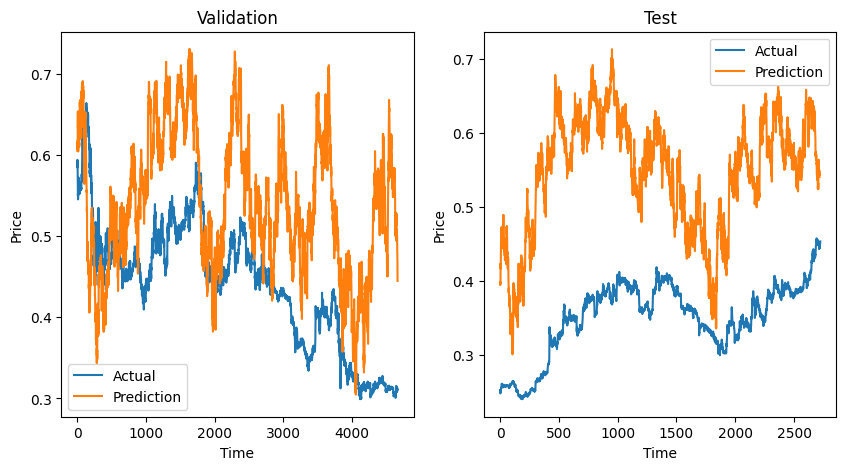

In [5]:
# Set Parameters

# delay: time in future that will be predicted
delay = 6


# sampling rate: period between timesteps within the sequence
# Sequence with rate=1 : t1,t2...tn
# Sequence with rate=3 : t1,t3...tn*3
sampling_rate = 2

# sequence length: sequence lenght of each sample 
sequence_length = 4 * 24


# sequence_stride: period between sequences
# First sequence starts at t0
# Second sequence will start at t1 with sequence_stride=1 or at t5 with sequence_stride=5
sequence_stride = 1

#batch_size: Number of timeseries samples in each batch (except maybe the last one). 
#If None, the data will not be batched (the dataset will yield individual samples).
# Huge impact in performance.
# Tip, should be multiple of 8
batch_size = 32

# Understanding our parameters
msg = f"The timeseries will consist of batches containing {batch_size} sequences of {sequence_length} samples."

msg += f"\nFinally our target is {delay} timesteps in the future, and will have data from {sequence_length * sampling_rate} timesteps in the past"
print(msg)

train_dataset = keras.preprocessing.timeseries_dataset_from_array(
                        raw_data[:-delay],
                    targets=close[delay:],
                    sampling_rate=sampling_rate,
                    sequence_stride=sequence_stride,
                    sequence_length=sequence_length,
                    shuffle=False, # Shouldn't the shuffle be set to 0?
                    seed=33,
                    batch_size=batch_size,
                    start_index=0,
                    end_index=num_train_samples)

print("Done Train")

val_dataset = keras.preprocessing.timeseries_dataset_from_array(
                    raw_data[:-delay],
                    targets=close[delay:],
                    sampling_rate=sampling_rate,
                    sequence_stride=sequence_stride,
                    sequence_length=sequence_length,
                    shuffle=False,
                    seed=33,
                    batch_size=batch_size,
                    start_index=num_train_samples,
                    end_index=num_train_samples + num_val_samples)

print("Done Validation")      

test_dataset = keras.preprocessing.timeseries_dataset_from_array(
                    raw_data[:-delay],
                    targets=close[delay:],
                    sampling_rate=sampling_rate,
                    sequence_stride=sequence_stride,
                    sequence_length=sequence_length,
                    shuffle=False,
                    seed=33,
                    batch_size=batch_size,
                    start_index=num_train_samples + num_val_samples)

print("Done Test")


# Load the saved model
model = keras.models.load_model("ADA/lstm_model_6_ahead.h5")
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

val_pred = model.predict(val_dataset)
test_pred = model.predict(test_dataset)


val_real = close[num_train_samples:num_train_samples + num_val_samples- (sequence_length * sampling_rate)+1]
test_real = close[num_train_samples + num_val_samples:-(sequence_length * sampling_rate)+1]

print(len(val_pred) == len(val_real), len(val_pred) , len(val_real), )
print(len(test_pred) == len(test_real), len(test_pred) , len(test_real))


# Assume 'y_normalized' contains the predicted values for the 'target' column in normalized form
y_min = df['close'].min()
y_max = df['close'].max()

val_real = val_real * (y_max - y_min) + y_min
val_pred = val_pred * (y_max - y_min) + y_min

test_real = test_real * (y_max - y_min) + y_min
test_pred = test_pred * (y_max - y_min) + y_min

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))

# Plot a and b in the left-hand subplot
ax1.set_title('Validation')
ax1.plot(val_real, label='Actual')
ax1.plot(val_pred, label='Prediction')
ax1.set_xlabel('Time')
ax1.set_ylabel('Price')
ax1.legend()

# Plot c and d in the right-hand subplot
ax2.set_title('Test')
ax2.plot(test_real, label='Actual')
ax2.plot(test_pred, label='Prediction')
ax2.set_xlabel('Time')
ax2.set_ylabel('Price')
ax2.legend()

# Display the plot
plt.show()

The timeseries will consist of batches containing 32 sequences of 96 samples.
Finally our target is 12 timesteps in the future, and will have data from 288 timesteps in the past
Done Train
Done Validation
Done Test


2023-05-14 17:27:43.913561: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-14 17:27:43.915284: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-14 17:27:43.916592: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

  7/143 [>.............................] - ETA: 1s  

2023-05-14 17:27:44.275131: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-14 17:27:44.277263: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-14 17:27:44.278917: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

13/82 [===>..........................] - ETA: 0s

2023-05-14 17:27:45.839875: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_20' with dtype double and shape [2903,1]
	 [[{{node Placeholder/_20}}]]
2023-05-14 17:27:45.840419: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_13' with dtype int32
	 [[{{node Placeholder/_13}}]]


82/82 [==============================] - 1s 10ms/step
True 4570 4570
False 2616 2628


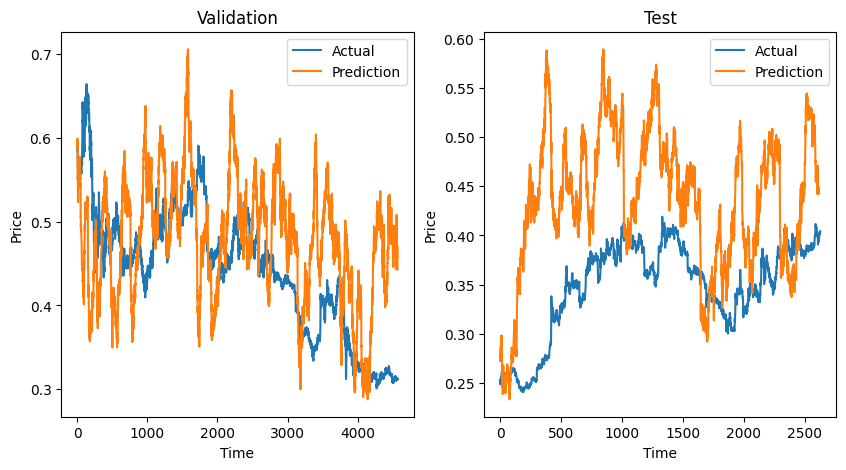

In [6]:
# Set Parameters

# delay: time in future that will be predicted
delay = 12


# sampling rate: period between timesteps within the sequence
# Sequence with rate=1 : t1,t2...tn
# Sequence with rate=3 : t1,t3...tn*3
sampling_rate = 3

# sequence length: sequence lenght of each sample 
sequence_length = 4 * 24


# sequence_stride: period between sequences
# First sequence starts at t0
# Second sequence will start at t1 with sequence_stride=1 or at t5 with sequence_stride=5
sequence_stride = 1

#batch_size: Number of timeseries samples in each batch (except maybe the last one). 
#If None, the data will not be batched (the dataset will yield individual samples).
# Huge impact in performance.
# Tip, should be multiple of 8
batch_size = 32

# Understanding our parameters
msg = f"The timeseries will consist of batches containing {batch_size} sequences of {sequence_length} samples."

msg += f"\nFinally our target is {delay} timesteps in the future, and will have data from {sequence_length * sampling_rate} timesteps in the past"
print(msg)

train_dataset = keras.preprocessing.timeseries_dataset_from_array(
                        raw_data[:-delay],
                    targets=close[delay:],
                    sampling_rate=sampling_rate,
                    sequence_stride=sequence_stride,
                    sequence_length=sequence_length,
                    shuffle=False, # Shouldn't the shuffle be set to 0?
                    seed=33,
                    batch_size=batch_size,
                    start_index=0,
                    end_index=num_train_samples)

print("Done Train")

val_dataset = keras.preprocessing.timeseries_dataset_from_array(
                    raw_data[:-delay],
                    targets=close[delay:],
                    sampling_rate=sampling_rate,
                    sequence_stride=sequence_stride,
                    sequence_length=sequence_length,
                    shuffle=False,
                    seed=33,
                    batch_size=batch_size,
                    start_index=num_train_samples,
                    end_index=num_train_samples + num_val_samples)

print("Done Validation")      

test_dataset = keras.preprocessing.timeseries_dataset_from_array(
                    raw_data[:-delay],
                    targets=close[delay:],
                    sampling_rate=sampling_rate,
                    sequence_stride=sequence_stride,
                    sequence_length=sequence_length,
                    shuffle=False,
                    seed=33,
                    batch_size=batch_size,
                    start_index=num_train_samples + num_val_samples)

print("Done Test")


# Load the saved model
model = keras.models.load_model("ADA/lstm_model_12_ahead.h5")
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

val_pred = model.predict(val_dataset)
test_pred = model.predict(test_dataset)


val_real = close[num_train_samples:num_train_samples + num_val_samples- (sequence_length * sampling_rate)+1]
test_real = close[num_train_samples + num_val_samples:-(sequence_length * sampling_rate)+1]

print(len(val_pred) == len(val_real), len(val_pred) , len(val_real), )
print(len(test_pred) == len(test_real), len(test_pred) , len(test_real))


# Assume 'y_normalized' contains the predicted values for the 'target' column in normalized form
y_min = df['close'].min()
y_max = df['close'].max()

val_real = val_real * (y_max - y_min) + y_min
val_pred = val_pred * (y_max - y_min) + y_min

test_real = test_real * (y_max - y_min) + y_min
test_pred = test_pred * (y_max - y_min) + y_min

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))

# Plot a and b in the left-hand subplot
ax1.set_title('Validation')
ax1.plot(val_real, label='Actual')
ax1.plot(val_pred, label='Prediction')
ax1.set_xlabel('Time')
ax1.set_ylabel('Price')
ax1.legend()

# Plot c and d in the right-hand subplot
ax2.set_title('Test')
ax2.plot(test_real, label='Actual')
ax2.plot(test_pred, label='Prediction')
ax2.set_xlabel('Time')
ax2.set_ylabel('Price')
ax2.legend()

# Display the plot
plt.show()

The timeseries will consist of batches containing 32 sequences of 96 samples.
Finally our target is 24 timesteps in the future, and will have data from 288 timesteps in the past
Done Train
Done Validation
Done Test


2023-05-14 17:27:47.517347: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-14 17:27:47.519266: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-14 17:27:47.520576: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

  7/143 [>.............................] - ETA: 1s  

2023-05-14 17:27:47.870393: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-14 17:27:47.872298: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-14 17:27:47.873955: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

13/82 [===>..........................] - ETA: 0s

2023-05-14 17:27:49.435513: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]
2023-05-14 17:27:49.436049: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [2891,72]
	 [[{{node Placeholder/_0}}]]


82/82 [==============================] - 1s 9ms/step
True 4570 4570
False 2604 2628


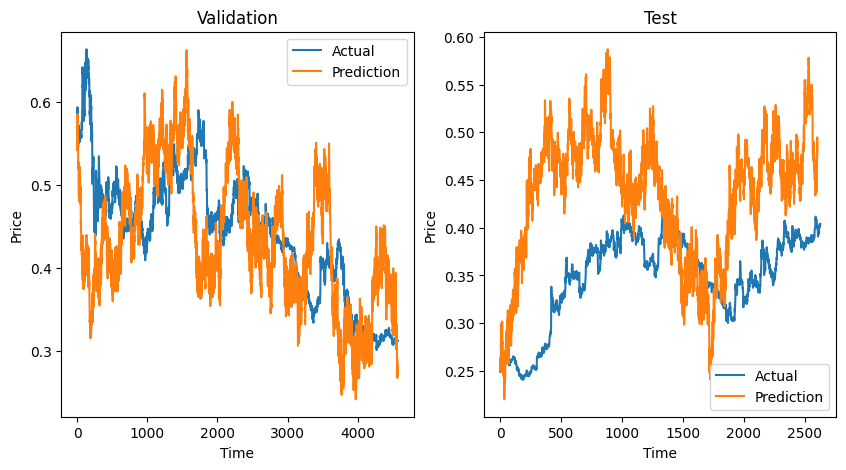

In [7]:
# Set Parameters

# delay: time in future that will be predicted
delay = 24


# sampling rate: period between timesteps within the sequence
# Sequence with rate=1 : t1,t2...tn
# Sequence with rate=3 : t1,t3...tn*3
sampling_rate = 3

# sequence length: sequence lenght of each sample 
sequence_length = 4 * 24


# sequence_stride: period between sequences
# First sequence starts at t0
# Second sequence will start at t1 with sequence_stride=1 or at t5 with sequence_stride=5
sequence_stride = 1

#batch_size: Number of timeseries samples in each batch (except maybe the last one). 
#If None, the data will not be batched (the dataset will yield individual samples).
# Huge impact in performance.
# Tip, should be multiple of 8
batch_size = 32

# Understanding our parameters
msg = f"The timeseries will consist of batches containing {batch_size} sequences of {sequence_length} samples."

msg += f"\nFinally our target is {delay} timesteps in the future, and will have data from {sequence_length * sampling_rate} timesteps in the past"
print(msg)

train_dataset = keras.preprocessing.timeseries_dataset_from_array(
                        raw_data[:-delay],
                    targets=close[delay:],
                    sampling_rate=sampling_rate,
                    sequence_stride=sequence_stride,
                    sequence_length=sequence_length,
                    shuffle=False, # Shouldn't the shuffle be set to 0?
                    seed=33,
                    batch_size=batch_size,
                    start_index=0,
                    end_index=num_train_samples)

print("Done Train")

val_dataset = keras.preprocessing.timeseries_dataset_from_array(
                    raw_data[:-delay],
                    targets=close[delay:],
                    sampling_rate=sampling_rate,
                    sequence_stride=sequence_stride,
                    sequence_length=sequence_length,
                    shuffle=False,
                    seed=33,
                    batch_size=batch_size,
                    start_index=num_train_samples,
                    end_index=num_train_samples + num_val_samples)

print("Done Validation")      

test_dataset = keras.preprocessing.timeseries_dataset_from_array(
                    raw_data[:-delay],
                    targets=close[delay:],
                    sampling_rate=sampling_rate,
                    sequence_stride=sequence_stride,
                    sequence_length=sequence_length,
                    shuffle=False,
                    seed=33,
                    batch_size=batch_size,
                    start_index=num_train_samples + num_val_samples)

print("Done Test")


# Load the saved model
model = keras.models.load_model("ADA/lstm_model_24_ahead.h5")
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

val_pred = model.predict(val_dataset)
test_pred = model.predict(test_dataset)


val_real = close[num_train_samples:num_train_samples + num_val_samples- (sequence_length * sampling_rate)+1]
test_real = close[num_train_samples + num_val_samples:-(sequence_length * sampling_rate)+1]

print(len(val_pred) == len(val_real), len(val_pred) , len(val_real), )
print(len(test_pred) == len(test_real), len(test_pred) , len(test_real))


# Assume 'y_normalized' contains the predicted values for the 'target' column in normalized form
y_min = df['close'].min()
y_max = df['close'].max()

val_real = val_real * (y_max - y_min) + y_min
val_pred = val_pred * (y_max - y_min) + y_min

test_real = test_real * (y_max - y_min) + y_min
test_pred = test_pred * (y_max - y_min) + y_min

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))

# Plot a and b in the left-hand subplot
ax1.set_title('Validation')
ax1.plot(val_real, label='Actual')
ax1.plot(val_pred, label='Prediction')
ax1.set_xlabel('Time')
ax1.set_ylabel('Price')
ax1.legend()

# Plot c and d in the right-hand subplot
ax2.set_title('Test')
ax2.plot(test_real, label='Actual')
ax2.plot(test_pred, label='Prediction')
ax2.set_xlabel('Time')
ax2.set_ylabel('Price')
ax2.legend()

# Display the plot
plt.show()

The timeseries will consist of batches containing 32 sequences of 120 samples.
Finally our target is 72 timesteps in the future, and will have data from 480 timesteps in the past
Done Train
Done Validation
Done Test


2023-05-14 17:27:51.053508: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-14 17:27:51.055246: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-14 17:27:51.056535: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

  5/137 [>.............................] - ETA: 1s  

2023-05-14 17:27:51.405881: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-14 17:27:51.408020: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-14 17:27:51.409631: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

11/74 [===>..........................] - ETA: 0s

2023-05-14 17:27:53.191687: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [2364]
	 [[{{node Placeholder/_8}}]]
2023-05-14 17:27:53.192232: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_28' with dtype int32 and shape [2364]
	 [[{{node Placeholder/_28}}]]


74/74 [==============================] - 1s 12ms/step
True 4378 4378
False 2364 2436


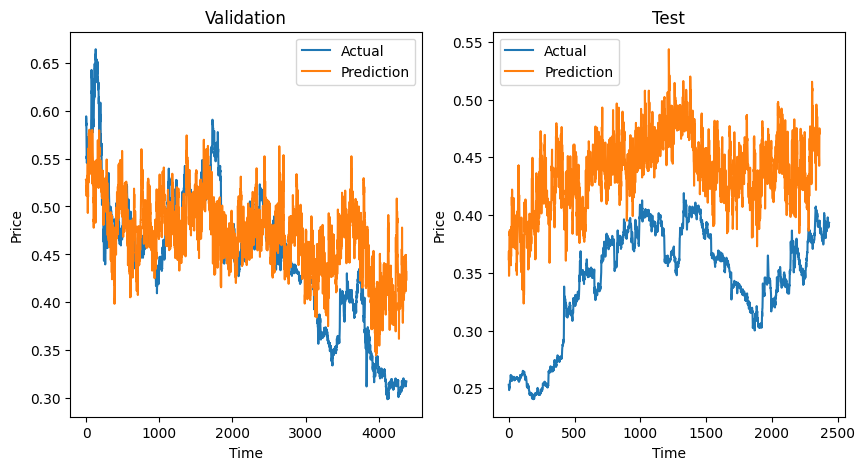

In [8]:
# Set Parameters

# delay: time in future that will be predicted
delay = 3*24


# sampling rate: period between timesteps within the sequence
# Sequence with rate=1 : t1,t2...tn
# Sequence with rate=3 : t1,t3...tn*3
sampling_rate = 4

# sequence length: sequence lenght of each sample 
sequence_length = 5 * 24


# sequence_stride: period between sequences
# First sequence starts at t0
# Second sequence will start at t1 with sequence_stride=1 or at t5 with sequence_stride=5
sequence_stride = 1

#batch_size: Number of timeseries samples in each batch (except maybe the last one). 
#If None, the data will not be batched (the dataset will yield individual samples).
# Huge impact in performance.
# Tip, should be multiple of 8
batch_size = 32

# Understanding our parameters
msg = f"The timeseries will consist of batches containing {batch_size} sequences of {sequence_length} samples."

msg += f"\nFinally our target is {delay} timesteps in the future, and will have data from {sequence_length * sampling_rate} timesteps in the past"
print(msg)

train_dataset = keras.preprocessing.timeseries_dataset_from_array(
                        raw_data[:-delay],
                    targets=close[delay:],
                    sampling_rate=sampling_rate,
                    sequence_stride=sequence_stride,
                    sequence_length=sequence_length,
                    shuffle=False, # Shouldn't the shuffle be set to 0?
                    seed=33,
                    batch_size=batch_size,
                    start_index=0,
                    end_index=num_train_samples)

print("Done Train")

val_dataset = keras.preprocessing.timeseries_dataset_from_array(
                    raw_data[:-delay],
                    targets=close[delay:],
                    sampling_rate=sampling_rate,
                    sequence_stride=sequence_stride,
                    sequence_length=sequence_length,
                    shuffle=False,
                    seed=33,
                    batch_size=batch_size,
                    start_index=num_train_samples,
                    end_index=num_train_samples + num_val_samples)

print("Done Validation")      

test_dataset = keras.preprocessing.timeseries_dataset_from_array(
                    raw_data[:-delay],
                    targets=close[delay:],
                    sampling_rate=sampling_rate,
                    sequence_stride=sequence_stride,
                    sequence_length=sequence_length,
                    shuffle=False,
                    seed=33,
                    batch_size=batch_size,
                    start_index=num_train_samples + num_val_samples)

print("Done Test")


# Load the saved model
model = keras.models.load_model("ADA/lstm_model_3d_ahead.h5")
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

val_pred = model.predict(val_dataset)
test_pred = model.predict(test_dataset)


val_real = close[num_train_samples:num_train_samples + num_val_samples- (sequence_length * sampling_rate)+1]
test_real = close[num_train_samples + num_val_samples:-(sequence_length * sampling_rate)+1]

print(len(val_pred) == len(val_real), len(val_pred) , len(val_real), )
print(len(test_pred) == len(test_real), len(test_pred) , len(test_real))


# Assume 'y_normalized' contains the predicted values for the 'target' column in normalized form
y_min = df['close'].min()
y_max = df['close'].max()

val_real = val_real * (y_max - y_min) + y_min
val_pred = val_pred * (y_max - y_min) + y_min

test_real = test_real * (y_max - y_min) + y_min
test_pred = test_pred * (y_max - y_min) + y_min

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))

# Plot a and b in the left-hand subplot
ax1.set_title('Validation')
ax1.plot(val_real, label='Actual')
ax1.plot(val_pred, label='Prediction')
ax1.set_xlabel('Time')
ax1.set_ylabel('Price')
ax1.legend()

# Plot c and d in the right-hand subplot
ax2.set_title('Test')
ax2.plot(test_real, label='Actual')
ax2.plot(test_pred, label='Prediction')
ax2.set_xlabel('Time')
ax2.set_ylabel('Price')
ax2.legend()

# Display the plot
plt.show()

The timeseries will consist of batches containing 32 sequences of 120 samples.
Finally our target is 168 timesteps in the future, and will have data from 720 timesteps in the past
Done Train
Done Validation
Done Test


2023-05-14 17:27:54.922351: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-14 17:27:54.924199: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-14 17:27:54.925583: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

  6/130 [>.............................] - ETA: 1s 

2023-05-14 17:27:55.283987: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-14 17:27:55.286030: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-14 17:27:55.287677: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

11/64 [====>.........................] - ETA: 0s

2023-05-14 17:27:56.985472: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [2747,72]
	 [[{{node Placeholder/_0}}]]
2023-05-14 17:27:56.986015: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [2028]
	 [[{{node Placeholder/_8}}]]


64/64 [==============================] - 1s 12ms/step
True 4138 4138
False 2028 2196


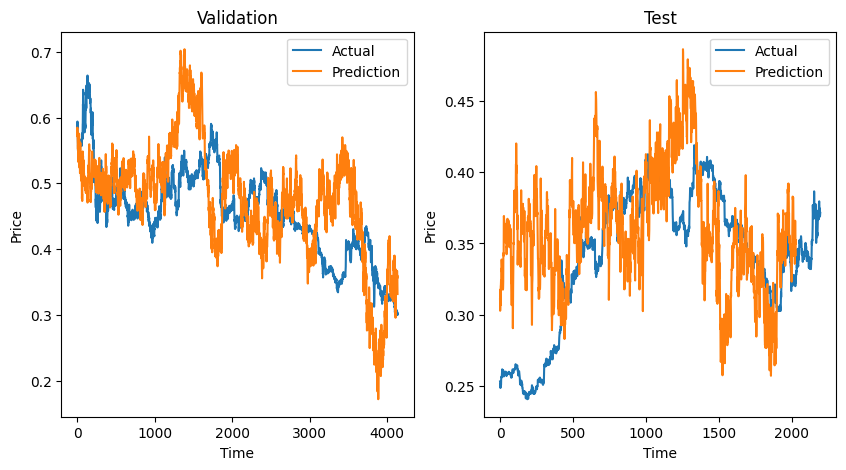

In [9]:
# Set Parameters

# delay: time in future that will be predicted
delay = 7*24


# sampling rate: period between timesteps within the sequence
# Sequence with rate=1 : t1,t2...tn
# Sequence with rate=3 : t1,t3...tn*3
sampling_rate = 6

# sequence length: sequence lenght of each sample 
sequence_length = 5 * 24


# sequence_stride: period between sequences
# First sequence starts at t0
# Second sequence will start at t1 with sequence_stride=1 or at t5 with sequence_stride=5
sequence_stride = 1

#batch_size: Number of timeseries samples in each batch (except maybe the last one). 
#If None, the data will not be batched (the dataset will yield individual samples).
# Huge impact in performance.
# Tip, should be multiple of 8
batch_size = 32

# Understanding our parameters
msg = f"The timeseries will consist of batches containing {batch_size} sequences of {sequence_length} samples."

msg += f"\nFinally our target is {delay} timesteps in the future, and will have data from {sequence_length * sampling_rate} timesteps in the past"
print(msg)

train_dataset = keras.preprocessing.timeseries_dataset_from_array(
                        raw_data[:-delay],
                    targets=close[delay:],
                    sampling_rate=sampling_rate,
                    sequence_stride=sequence_stride,
                    sequence_length=sequence_length,
                    shuffle=False, # Shouldn't the shuffle be set to 0?
                    seed=33,
                    batch_size=batch_size,
                    start_index=0,
                    end_index=num_train_samples)

print("Done Train")

val_dataset = keras.preprocessing.timeseries_dataset_from_array(
                    raw_data[:-delay],
                    targets=close[delay:],
                    sampling_rate=sampling_rate,
                    sequence_stride=sequence_stride,
                    sequence_length=sequence_length,
                    shuffle=False,
                    seed=33,
                    batch_size=batch_size,
                    start_index=num_train_samples,
                    end_index=num_train_samples + num_val_samples)

print("Done Validation")      

test_dataset = keras.preprocessing.timeseries_dataset_from_array(
                    raw_data[:-delay],
                    targets=close[delay:],
                    sampling_rate=sampling_rate,
                    sequence_stride=sequence_stride,
                    sequence_length=sequence_length,
                    shuffle=False,
                    seed=33,
                    batch_size=batch_size,
                    start_index=num_train_samples + num_val_samples)

print("Done Test")


# Load the saved model
model = keras.models.load_model("ADA/lstm_model_7d_ahead.h5")
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

val_pred = model.predict(val_dataset)
test_pred = model.predict(test_dataset)


val_real = close[num_train_samples:num_train_samples + num_val_samples- (sequence_length * sampling_rate)+1]
test_real = close[num_train_samples + num_val_samples:-(sequence_length * sampling_rate)+1]

print(len(val_pred) == len(val_real), len(val_pred) , len(val_real), )
print(len(test_pred) == len(test_real), len(test_pred) , len(test_real))


# Assume 'y_normalized' contains the predicted values for the 'target' column in normalized form
y_min = df['close'].min()
y_max = df['close'].max()

val_real = val_real * (y_max - y_min) + y_min
val_pred = val_pred * (y_max - y_min) + y_min

test_real = test_real * (y_max - y_min) + y_min
test_pred = test_pred * (y_max - y_min) + y_min

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))

# Plot a and b in the left-hand subplot
ax1.set_title('Validation')
ax1.plot(val_real, label='Actual')
ax1.plot(val_pred, label='Prediction')
ax1.set_xlabel('Time')
ax1.set_ylabel('Price')
ax1.legend()

# Plot c and d in the right-hand subplot
ax2.set_title('Test')
ax2.plot(test_real, label='Actual')
ax2.plot(test_pred, label='Prediction')
ax2.set_xlabel('Time')
ax2.set_ylabel('Price')
ax2.legend()

# Display the plot
plt.show()